# Test 4 - Site explicit modelling under Mott-Schottky conditions including the additional site charge.

**Running the code in this notebook takes approximately 3 minutes. (iMac with 4 Ghz i7 processor).**

This notebook can be run to verify that the code is working as expected using the site explicit model under Mott-Schottky conditions, including the additional site charge.
The data collected by running this notebook is a DataFrame, saved in `output_data.csv` which contains information about the conditions applied to the calculation, the $x$ coordinate data, and the calculated electrostatic potential, charge density and input and output defect mole fraction. A DataFrame stored in `key_data.dat`, which includes the calculated space charge properties and a saved figure for the elctrostatic potential, charge density and defect mole fractions as a function of $x$.
The outputs from running this notebook will be stored in the `generated_outputs` directory and can be compared to the controlled outputs previously calculated in `expected_outputs` directory. 

In [1]:
from pyscses.defect_species import DefectSpecies
from pyscses.structure_data import StructureData
from pyscses.set_of_sites import SetOfSites
from pyscses.constants import boltzmann_eV
from pyscses.calculation import Calculation, calculate_activation_energies
from pyscses.grid import Grid

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if not os.path.isdir('generated_outputs'):
    os.mkdir('generated_outputs')

In [3]:
boundary_conditions = 'periodic'
site_charges = True
systems = 'mott-schottky'
core_models = False
site_models = 'site_explicit'
scaling = True

In [4]:
alpha = 0.0005
conv = 1e-8
grid_x_limits = [-6.094e-9, 5.16e-9]
bulk_x_min = -5.783e-9
bulk_x_max = -3.502e-9

dielectric = 55

index = 111
b = 7.65327e-10
c = 7.65327e-10

temp = [ 773.15 ]

In [5]:
valence = [ +2.0, -1.0 ]
site_labels = [ 'O', 'Ce' ]
defect_labels = ['Vo', 'Gd']
mole_fractions = np.array([[ 0.05, 0.2 ]])
initial_guess = np.array([[ 0.05, 0.2 ]])
mobilities = [ 1.0, 0.0 ]
able_to_equilibrate = [True, False]

In [6]:
data = '../input_data/Gd_CeO2_111_data.txt'

In [7]:
labels=['core_model', 'site_model', 'MS_GC', 'site_charge', 
        'resistivity_scaling', 'temperature', 'input_mole_fractions', 
        'x', 'phi', 'rho', 'Vo_mole_fraction', 'Gd_mole_fraction']
output_data = pd.DataFrame(columns=labels)
filename = 'generated_outputs/output_data.csv'

In [8]:
structure_data = StructureData.from_file(filename=data,
                                         x_limits=grid_x_limits,
                                         b=b,
                                         c=c,
                                         site_charge=True)

In [9]:

for m in mole_fractions:
    for t in temp:
    
        defect_species = [DefectSpecies(label=l,
                                        valence=v,
                                        mole_fraction=m,
                                        mobility=mob,
                                       can_equilibrate = eq)
                          for l, v, m, mob, eq
                          in zip(defect_labels, valence, m, mobilities, able_to_equilibrate)]

        all_sites = SetOfSites.from_sites_data(sites_data=structure_data.sites_data,
                                               defect_species=defect_species, verbose = True)
        for site in all_sites.subset( 'Ce' ):
            site.defect_with_label('Gd').fixed = True
        grid = Grid.from_set_of_sites(all_sites,
                                      structure_data.limits,
                                      structure_data.laplacian_limits,
                                      structure_data.b,
                                      structure_data.c)
        
        c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, dielectric, t, boundary_conditions )
        c_o.form_subgrids( site_labels )

        c_o.solve(systems, verbose=True)
        c_o.mole_fractions()
        c_o.calculate_resistivity_ratio( 'positive', 2e-2 )
        c_o.solve_MS_approx_for_phi( valence[0] )
        
        output_data['x'] = grid.x
        output_data['phi'] = c_o.phi
        output_data['rho'] = c_o.rho
        output_data['Vo_mole_fraction'] = c_o.mf[site_labels[0]]
        output_data['Gd_mole_fraction'] = c_o.mf[site_labels[1]]
        output_data['core_model'] = str(core_models)
        output_data['site_model'] = str(site_models)
        output_data['MS_GC'] = str(systems)
        output_data['site_charge'] = str(site_charges)
        output_data['resistivity_scaling'] = str(scaling)
        output_data['temperature'] = t
        output_data['input_mole_fractions'] = str(m)
        output_data.to_csv(filename, index=False)
        
        key_data = np.column_stack(( max(c_o.phi)-c_o.phi[1], c_o.perpendicular_resistivity_ratio, c_o.parallel_resistivity_ratio ))
        np.savetxt( 'generated_outputs/key_data.dat', key_data )     


Defect species Vo has valence 2.0, bulk mole fraction 0.05, and mobility 1.0. Defect species Vo can equilibrate.
Defect species Gd has valence -1.0, bulk mole fraction 0.2, and mobility 0.0. Defect species Gd cannot equilibrate.
Iteration: 500 -> Convergence: 0.31673881036531654 / 1e-08
Iteration: 1000 -> Convergence: 0.21726803423898108 / 1e-08
Iteration: 1500 -> Convergence: 0.1652688359844799 / 1e-08
Iteration: 2000 -> Convergence: 0.1278032391830924 / 1e-08
Iteration: 2500 -> Convergence: 0.0984278615772384 / 1e-08
Iteration: 3000 -> Convergence: 0.07593506974383418 / 1e-08
Iteration: 3500 -> Convergence: 0.05918224742669426 / 1e-08
Iteration: 4000 -> Convergence: 0.04600830595821248 / 1e-08
Iteration: 4500 -> Convergence: 0.03573789564441848 / 1e-08
Iteration: 5000 -> Convergence: 0.027757876494166667 / 1e-08
Iteration: 5500 -> Convergence: 0.02156424452232608 / 1e-08
Iteration: 6000 -> Convergence: 0.016757713770002902 / 1e-08
Iteration: 6500 -> Convergence: 0.013026645231075162 

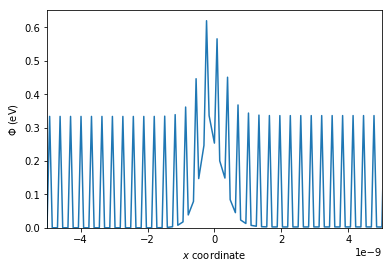

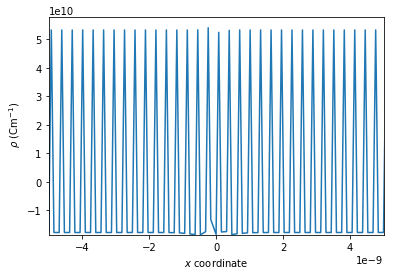

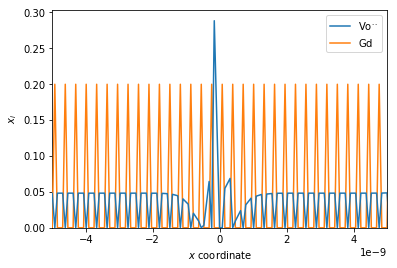

In [10]:
plt.plot(grid.x, c_o.phi)
plt.xlabel( '$x$ $\mathrm{coordinate}$' )
plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
plt.xlim( -5e-9, 5e-9)
plt.ylim(min(c_o.phi))
plt.savefig('generated_outputs/x_vs_potential.pdf')
plt.show()

plt.plot(grid.x, c_o.rho)
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel(' $ \\rho $ $(\mathrm{C m}^{-1})$')
plt.xlim( -5e-9, 5e-9)
plt.ylim(min(c_o.rho))
plt.savefig('generated_outputs/x_vs_chargedensity.pdf')
plt.show()

plt.plot(grid.x, c_o.mf[site_labels[0]], label = '$\mathrm{Vo}^{..}$', zorder = 5.0)
plt.plot(grid.x, c_o.mf[site_labels[1]], label = '$\mathrm{Gd}$', zorder = 4.0)
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel('$x_{i}$')
plt.xlim( -5e-9, 5e-9)
plt.ylim(0.0)
plt.legend()
plt.savefig('generated_outputs/x_vs_molefractions.pdf')
plt.show()